In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import seaborn as sns
import pandas as pd
from scipy import signal
from importlib import reload

import winsound as sd
import pickle
import sys
import os

In [2]:
# load
cd = os.getcwd()
path = os.path.dirname(cd)
    
with open(path+'//Data_final.pkl', 'rb') as file:
    Filt_idata = pickle.load(file)
    Filt_gdata = pickle.load(file)
    Filt_glen = pickle.load(file)
    F_DataLen = pickle.load(file)
    
    Af_py = pickle.load(file)
    Af_in = pickle.load(file)
    
    In_py_list = pickle.load(file)
    In_in_list = pickle.load(file)

In [3]:
with open(path+'//module//Weights_Sim//Learned weights-sim_encoding.pkl', 'rb') as file:
    DG_E_list = pickle.load(file)
    CA3_E_list = pickle.load(file)
    CA1_E_list = pickle.load(file)

In [4]:
with open(path+'//module//Weights_Sim//Learned weights-sim_144.pkl', 'rb') as file:
    DG_E_T = pickle.load(file)
    CA3_E_T = pickle.load(file)
    CA1_E_T = pickle.load(file)

In [5]:
targetCA1 = [ 12,  14,  15,  21,  22,  31,  35,  37,  40,  56,  59,  74,  77,
         87,  88,  93,  94,  96, 104, 109, 111, 113, 116, 122, 135, 136,
        141, 150, 157, 164, 166, 182, 186, 192, 193, 196]

In [6]:
temp = np.zeros(200)
temp[targetCA1] = 1
CA1_E_T = [temp]

In [7]:
#             pickle.dump(network.q_ppCA3, file)
#             pickle.dump(network.q_Rc, file)
#             pickle.dump(network.q_CA33i, file)
#             pickle.dump(network.q_Sc, file)

In [8]:
# 전반적인 cue 200개에 대한 결과
path_results = '//module//Results_sim'

for n in range(105):
    with open(path+path_results+'//Results-sim%d.pkl' %(n), 'rb') as file:
        globals()["Success{}".format(n)] = pickle.load(file)
        globals()["Fail{}".format(n)] = pickle.load(file)
        globals()["If_fail{}".format(n)] = pickle.load(file)
        
        globals()["CA3_R_list{}".format(n)] = pickle.load(file)
        globals()["CA1_R_list{}".format(n)] = pickle.load(file)

In [9]:
with open(path+'//module//Cue_Sim_v2.pkl', 'rb') as file:
    Cue_Data = pickle.load(file)

In [10]:
def cal_overlap(total,A,B):
    if (len(A)+len(B)) !=0:
        output = len(A.intersection(B))*2 / (len(A)+len(B))
    else:
        output = 0
    return output

In [11]:
def cal_relative_overlap_CA1(total, B, T):
    temp_list = []
    for i, comp in enumerate(Target_fin):
        temp2 = set(np.where(Filt_idata[:,comp]!=0)[0])
        temp_list.append(cal_overlap(total,temp2,B))
    if np.max(temp_list) !=0:
        temp_list = temp_list/np.max(temp_list)
        return temp_list[T]   
    else:
        return 0

In [12]:
def cal_relative_overlap_CA3(total, B, T):
    temp_list = []
    for i, comp in enumerate(Target_fin):
        temp2 = set(Af_py[comp])
        temp_list.append(cal_overlap(total,temp2,B))
    if np.max(temp_list) !=0:
        temp_list = temp_list/np.max(temp_list)
        return temp_list[T]   
    else:
        return 0           

In [13]:
def cal_relative_overlap_DG(total, B, T):
    temp_list = []
    for i, comp in enumerate(Target_fin):
        temp2 = set(np.where(Filt_gdata[:,comp]!=0)[0])
        temp_list.append(cal_overlap(total,temp2,B))
    if np.max(temp_list) !=0:
        temp_list = temp_list/np.max(temp_list)
        return temp_list[T]   
    else:
        return 0        

In [14]:
def calculate_success(CA3_R_list, CA1_R_list, CA3, Data, CN, num_cue, repeat):
    Trial = repeat
    Trial_CA3 = np.zeros(Trial)
    Trial_CA1 = np.zeros(Trial)
    Inter_CA1 = np.zeros(Trial)
    # CA3 firing rate
    N = 3
    # CA3 firing ratio
    R = 0.3
    Success = 0
    S_list = []
    Weird = 0
    Interference = 0
    Fail = 0
    Classify_num = CN
    Winner = np.zeros(Classify_num)

    # 각 trial 에서 CA3의 firing rate N 보다 큰 애들 인덱스
    # 각 엔그램이랑 겹치는 정도 R
    for i, comp in enumerate(CA3_R_list):
        temp = np.where(comp >= N)[0]
        # firing neuron과 target engram과의 overlap 정도 비교
        # 어느 하나로 수렴했으면 +1
        # 여러 엔그램으로 수렴했으면 1< 일 것
        for j, ca3 in enumerate(CA3):
            if len(ca3)== 0:
                Trial_CA3[i] += 0
            else:
                if len(set(temp).intersection(set(ca3)))/len(ca3) >= R:
                    Trial_CA3[i] += 1

    # 각 trial 에서 CA1의 firing rate 1보다 큰 애들 인덱스
    # 특정 인풋이랑 완전히 일치해야만 성공
    for i, comp in enumerate(CA1_R_list):
        # 일단 발화했으면 다 체크
        temp = np.where(comp >= 1)[0]
        # 그리고 최종적으로 발화한 애들이 2보단 많이 발화해야함
        temp2 = np.where(comp >= 2)[0]
        
        for j, data in enumerate(Data):
            # 일단 발화한 애들이 어떤 data로 수렴했고
            if len(temp) == len(data) and len(set(temp).intersection(set(data))) == len(temp):
                # 얘네가 충분히 rate가 크다면 +1
                if len(temp) == len(temp2):
                    Trial_CA1[i] += 1
                    Winner[j] += 1
            elif len(set(temp2)) !=0:
                Inter_CA1[i] += 1
        
    for n in range(Trial):
        if Trial_CA1[n] == 1:
            Success += 1
            S_list.append(1)
        # CA3에서 여러 engram이 발화했지만 성공했을 때
        #elif Trial_CA3[n] == 0 and Trial_CA1[n] == 1:
        #    Weird += 1
        #    S_list.append(0)
        # CA3에서 여러 engram이 발화하면서 성공도 못했을 때
        # 여러 engram이 발화했어도 CA1에 영향없으면 괜찮기 때문
        elif Inter_CA1[n] != 0 and Trial_CA3[n] > 1:
            Interference += 1
            S_list.append(0)
        else:
            Fail += 1
            S_list.append(0)
    print('Success : ', Success)
    #print('Weird : ', Weird)
    print('Interference : ', Interference)
    print('Fail : ', Fail)
    return Success, Winner, Trial_CA1, Trial_CA3

In [15]:
Target = Filt_idata[:,144]
Target = np.append(Target, Cue_Data[:,0])
Target = np.reshape(Target, (2,16)).T

In [16]:
len(CA3_E_list)

105

In [17]:
Num_cue = 105
Repeat = 30
Winner_list = np.zeros([2,Num_cue])
Success_list = np.zeros(Num_cue)
Trial_CA3_list = np.zeros([Repeat,Num_cue])
Trial_CA1_list = np.zeros([Repeat,Num_cue])
for n in range(Num_cue):
    CN = 2
    # target data neuron idx on comp task
    Data_CP = [np.where(Filt_idata[:,144] !=0)[0]]
    Data_CP.append(np.where(Cue_Data[:,n] !=0)[0])

    # target CA3 engram idx on competition task
    CA3_CP = [Af_py[144], list(np.where(CA3_E_list[n])[0])]
    Num_cue_p = 1
    Success_list[n], Winner_list[:,n], Trial_CA1_list[:,n], Trial_CA3_list[:,n] = calculate_success(globals()["CA3_R_list{}".format(n)], globals()["CA1_R_list{}".format(n)], CA3_CP, Data_CP, CN, Num_cue_p, Repeat)


Success :  22
Interference :  0
Fail :  8
Success :  28
Interference :  0
Fail :  2
Success :  9
Interference :  0
Fail :  21
Success :  27
Interference :  0
Fail :  3
Success :  0
Interference :  0
Fail :  30
Success :  25
Interference :  0
Fail :  5
Success :  0
Interference :  0
Fail :  30
Success :  19
Interference :  0
Fail :  11
Success :  2
Interference :  0
Fail :  28
Success :  19
Interference :  0
Fail :  11
Success :  2
Interference :  0
Fail :  28
Success :  29
Interference :  0
Fail :  1
Success :  2
Interference :  0
Fail :  28
Success :  27
Interference :  0
Fail :  3
Success :  23
Interference :  0
Fail :  7
Success :  19
Interference :  3
Fail :  8
Success :  23
Interference :  0
Fail :  7
Success :  28
Interference :  0
Fail :  2
Success :  21
Interference :  0
Fail :  9
Success :  14
Interference :  0
Fail :  16
Success :  21
Interference :  0
Fail :  9
Success :  22
Interference :  0
Fail :  8
Success :  21
Interference :  0
Fail :  9
Success :  20
Interference :  0

In [18]:
Target_fin = [144]

In [19]:
T_idx = 0
NN = Target_fin[T_idx]

In [20]:
Simlist_IN = []
Simlist_DG = []
Simlist_CA3 = []
Simlist_CA1 = []
Simlist_idx = []
# 각 cue에 대해 발화한 각 영역의 엔그램 idx
for n in range(Num_cue):
    Simlist_IN.append(np.where(Cue_Data[:,n] !=0)[0])
    Simlist_DG.append(np.where(DG_E_list[n] >= 1)[0])
    Simlist_CA3.append(np.where(CA3_E_list[n] >= 1)[0])
    Simlist_CA1.append(np.where(CA1_E_list[n] >= 1)[0])
    Simlist_idx.append(n)

In [21]:
with open('Over_En.pkl', 'wb') as file:
    pickle.dump(Simlist_IN, file)
    pickle.dump(Simlist_DG, file)
    pickle.dump(Simlist_CA3, file)
    pickle.dump(Simlist_CA1, file)
    pickle.dump(Simlist_idx, file)

In [22]:
# 
Pair_IN = []
Pair_DG = []
Pair_CA3 = []
Pair_CA1 = []
Pair_idx = []
idx_DG = []
idx_CA1 = []
idx_succ = []
for i, comp in enumerate(Simlist_DG):
    if len(comp) == 0:
        idx_DG.append(i)
for i, comp in enumerate(Simlist_CA1):
    if len(comp) == 0:
        idx_CA1.append(i)
# for i, comp in enumerate(Success_list):
#     if comp < 18:
#         idx_succ.append(i)
        
for i, comp in enumerate(Simlist_DG):
    if i not in idx_DG and i not in idx_CA1:
        if Simlist_idx[i] not in idx_succ:
            Pair_DG.append(1-cal_overlap(set(range(800)), set(np.where(Filt_gdata[:,NN]!=0)[0]), set(comp)))

                       
for i, comp in enumerate(Simlist_CA1):
    if i not in idx_DG and i not in idx_CA1:
        if Simlist_idx[i] not in idx_succ:
#        #Pair_CA1.append(1-cal_relative_overlap_CA1(set(range(16)), set(comp), T_idx))
            Pair_CA1.append(1-cal_overlap(set(range(200)), set(np.where(CA1_E_T)[1]), set(comp)))
        
for i, comp in enumerate(Simlist_IN):
    if i not in idx_DG and i not in idx_CA1:
        if Simlist_idx[i] not in idx_succ:
            Pair_IN.append(1-cal_overlap(set(range(16)), set(np.where(Filt_idata[:,NN]!=0)[0]), set(comp)))

for i, comp in enumerate(Simlist_CA3):
    if i not in idx_DG and i not in idx_CA1:
        if Simlist_idx[i] not in idx_succ:
            Pair_CA3.append(1-cal_overlap(set(range(2400)), set(Af_py[NN]), set(comp)))
        
for i, comp in enumerate(Simlist_idx):
    if Simlist_idx[i] not in idx_succ:
        if i not in idx_DG and i not in idx_CA1:      
            Pair_idx.append(comp)

In [23]:
len(Pair_idx)

49

In [24]:
Pair_IN_sum = np.zeros(Num_cue)
Pair_IN_idx = np.zeros(Num_cue)
for i, comp in enumerate(Pair_idx):
    Pair_IN_sum[comp] += Pair_IN[i]
    Pair_IN_idx[comp] += 1
    
Pair_IN_fin = Pair_IN_sum/Pair_IN_idx
Pair_IN_fin = Pair_IN_fin[~np.isnan(Pair_IN_fin)]

Pair_DG_sum = np.zeros(Num_cue)
Pair_DG_idx = np.zeros(Num_cue)
for i, comp in enumerate(Pair_idx):
    Pair_DG_sum[comp] += Pair_DG[i]
    Pair_DG_idx[comp] += 1
    
Pair_DG_fin = Pair_DG_sum/Pair_DG_idx
Pair_DG_fin = Pair_DG_fin[~np.isnan(Pair_DG_fin)]

Pair_CA3_sum = np.zeros(Num_cue)
Pair_CA3_idx = np.zeros(Num_cue)
for i, comp in enumerate(Pair_idx):
    Pair_CA3_sum[comp] += Pair_CA3[i]
    Pair_CA3_idx[comp] += 1
    
Pair_CA3_fin = Pair_CA3_sum/Pair_CA3_idx
Pair_CA3_fin = Pair_CA3_fin[~np.isnan(Pair_CA3_fin)]

Pair_CA1_sum = np.zeros(Num_cue)
Pair_CA1_idx = np.zeros(Num_cue)
for i, comp in enumerate(Pair_idx):
    Pair_CA1_sum[comp] += Pair_CA1[i]
    Pair_CA1_idx[comp] += 1
    
Pair_CA1_fin = Pair_CA1_sum/Pair_CA1_idx
Pair_CA1_fin = Pair_CA1_fin[~np.isnan(Pair_CA1_fin)]

C:\Users\fiat_\AppData\Local\Temp\ipykernel_17388\3065975168.py:7: RuntimeWarning: invalid value encountered in divide
  Pair_IN_fin = Pair_IN_sum/Pair_IN_idx
C:\Users\fiat_\AppData\Local\Temp\ipykernel_17388\3065975168.py:16: RuntimeWarning: invalid value encountered in divide
  Pair_DG_fin = Pair_DG_sum/Pair_DG_idx
C:\Users\fiat_\AppData\Local\Temp\ipykernel_17388\3065975168.py:25: RuntimeWarning: invalid value encountered in divide
  Pair_CA3_fin = Pair_CA3_sum/Pair_CA3_idx
C:\Users\fiat_\AppData\Local\Temp\ipykernel_17388\3065975168.py:34: RuntimeWarning: invalid value encountered in divide
  Pair_CA1_fin = Pair_CA1_sum/Pair_CA1_idx


In [25]:
temp1 = np.where(Pair_IN_fin < 0.4)[0]
temp3 = np.where(Pair_IN_fin > 0.1)[0]
temp2 = np.where(Pair_DG_fin < 0.1)[0]
temp4 = set(temp1).intersection(set(temp3))
tempf = set(temp2).intersection(temp4)
print(tempf)
for i, comp in enumerate(tempf):
    print(Pair_idx[comp])

{33, 35, 37, 38, 31}
79
83
85
86
77


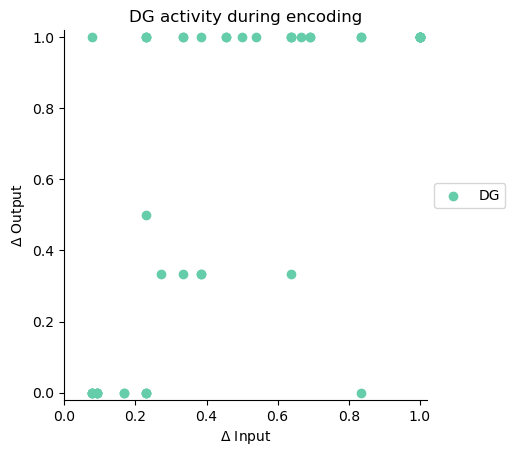

In [26]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(Pair_IN_fin, Pair_DG_fin, color='mediumaquamarine', label='DG')

#plt.scatter(DeltaIN, DeltaCA1, color='black', label='CA1')

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')
plt.axis("square")
plt.xlim([0,1.02])
plt.ylim([-0.02,1.02])
plt.xlabel('$\Delta$ Input')
plt.ylabel('$\Delta$ Output')
plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.title('DG activity during encoding')
plt.show()

In [27]:
for i, comp in enumerate(Pair_DG_fin):
    if comp == 0:
        print(Pair_IN_fin[i], Pair_idx[i])

0.8333333333333334 26
0.23076923076923073 77
0.16666666666666663 79
0.16666666666666663 83
0.23076923076923073 85
0.23076923076923073 86
0.09090909090909094 90
0.09090909090909094 91
0.09090909090909094 92
0.07692307692307687 96
0.09090909090909094 97
0.07692307692307687 98
0.07692307692307687 101
0.07692307692307687 104


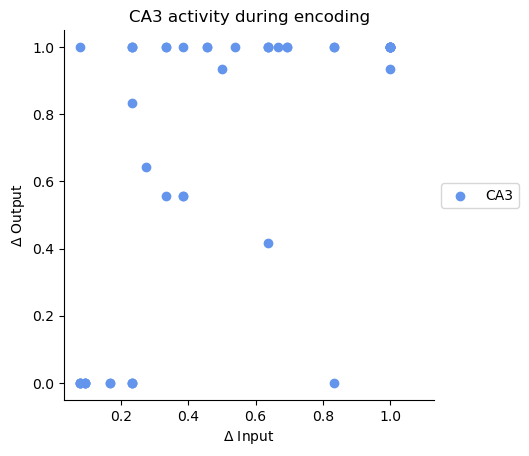

In [28]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(Pair_IN_fin, Pair_CA3_fin, color='cornflowerblue', label='CA3')
#plt.scatter(DeltaIN, DeltaCA1, color='black', label='CA1')

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('$\Delta$ Input')
plt.ylabel('$\Delta$ Output')
plt.axis("square")
plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.title('CA3 activity during encoding')
plt.show()

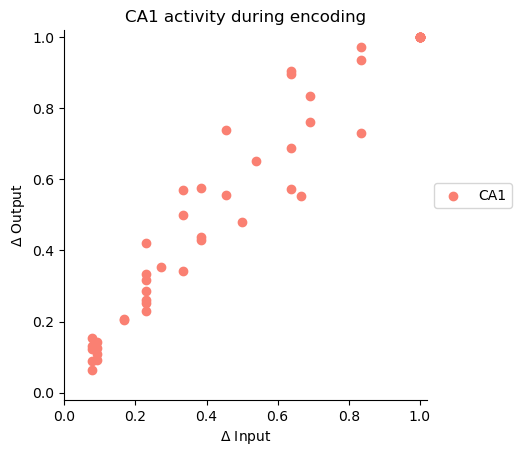

In [29]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(Pair_IN_fin, Pair_CA1_fin, color='salmon', label='CA1')
#plt.scatter(DeltaIN, DeltaCA1, color='black', label='CA1')

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')
plt.axis("square")
plt.xlim([0,1.02])
plt.ylim([-0.02,1.02])
plt.xlabel('$\Delta$ Input')
plt.ylabel('$\Delta$ Output')

plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.title('CA1 activity during encoding')
plt.show()

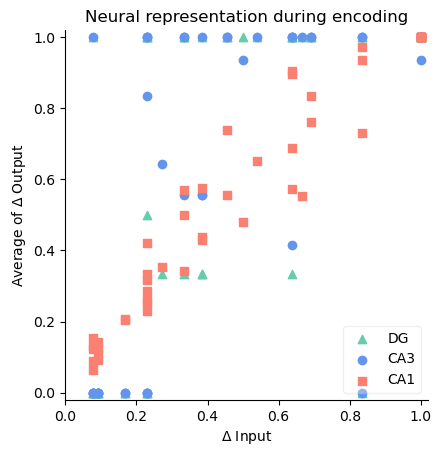

In [30]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(Pair_IN_fin, Pair_DG_fin, color='mediumaquamarine', marker='^', label='DG')
plt.scatter(Pair_IN_fin, Pair_CA3_fin, color='cornflowerblue', label='CA3')
plt.scatter(Pair_IN_fin, Pair_CA1_fin, color='salmon', marker=',', label='CA1')
#plt.scatter(DeltaIN, DeltaCA1, color='black', label='CA1')

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')
plt.legend(loc='lower right', framealpha=0.3)
plt.axis("square")
plt.xlim([0,1.02])
plt.ylim([-0.02,1.02])
plt.xlabel('$\Delta$ Input')
plt.ylabel('Average of $\Delta$ Output')

fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.title('Neural representation during encoding')
plt.savefig('Activity for each subregion during encoding.pdf', bbox_inches='tight')
plt.savefig('Activity for each subregion during encoding.tiff', bbox_inches='tight', dpi=300)
plt.show()

In [31]:
a

NameError: name 'a' is not defined

In [ ]:
DeltaIN = []
DeltaDG = []
DeltaCA3 = []
DeltaCA1 = []
Classfy_num = 40
for n in range(Classfy_num+1):
    DeltaIN.append([])
    DeltaDG.append([])
    DeltaCA3.append([])
    DeltaCA1.append([])
    
for i, comp in enumerate(Pair_IN_fin):
    if comp == 0:
        DeltaIN[0].append(comp)
        DeltaDG[0].append(Pair_DG_fin[i])
        DeltaCA3[0].append(Pair_CA3_fin[i])
        DeltaCA1[0].append(Pair_CA1_fin[i])
    else:
        for n in range(Classfy_num):    
            if (1/Classfy_num)*n < comp <= (1/Classfy_num)*n+(1/Classfy_num):
                DeltaIN[n+1].append(comp)
                DeltaDG[n+1].append(Pair_DG_fin[i])
                DeltaCA3[n+1].append(Pair_CA3_fin[i])
                DeltaCA1[n+1].append(Pair_CA1_fin[i])

DeltaIN_final = np.zeros(len(DeltaIN))
DeltaDG_final = np.zeros(len(DeltaDG))
DeltaCA3_final = np.zeros(len(DeltaCA3))
DeltaCA1_final = np.zeros(len(DeltaCA1))
for n in range(len(DeltaIN)):
    DeltaIN_final[n] = np.mean(DeltaIN[n])
    DeltaDG_final[n] = np.mean(DeltaDG[n])
    DeltaCA3_final[n] = np.mean(DeltaCA3[n])
    DeltaCA1_final[n] = np.mean(DeltaCA1[n])

In [ ]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(DeltaIN_final, DeltaDG_final, color='mediumaquamarine', marker='^', label='DG')
plt.scatter(DeltaIN_final, DeltaCA3_final, color='cornflowerblue', label='CA3')
plt.scatter(DeltaIN_final, DeltaCA1_final, color='salmon', marker=',', label='CA1')
#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')
plt.legend(loc='lower right')
plt.axis("square")
plt.xlim([0,1.02])
plt.ylim([-0.02,1.02])
plt.xlabel('$\Delta$ Input')
plt.ylabel('Average of $\Delta$ Output')

fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
plt.title('Neural representation during encoding')
plt.savefig('Activity for each subregion during encoding.pdf', bbox_inches='tight')
plt.show()

In [ ]:
a

In [ ]:
Overlap_I = []
Overlap_DG = []
Overlap_CA3 = []
Overlap_CA1 = []
Classfy_num = 100
for n in range(Classfy_num+1):
    Overlap_I.append([])
    Overlap_DG.append([])
    Overlap_CA3.append([])
    Overlap_CA1.append([])
    
for i, comp in enumerate(Pair_IN_fin):
    if comp == 0:
        Overlap_I[0].append(1-comp)
        Overlap_DG[0].append(1-Pair_DG_fin[i])
        Overlap_CA3[0].append(1-Pair_CA3_fin[i])
        Overlap_CA1[0].append(1-Pair_CA1_fin[i])
    else:
        for n in range(Classfy_num):    
            if (1/Classfy_num)*n < comp <= (1/Classfy_num)*n+(1/Classfy_num):
                Overlap_I[n+1].append(1-comp)
                Overlap_DG[n+1].append(1-Pair_DG_fin[i])
                Overlap_CA3[n+1].append(1-Pair_CA3_fin[i])
                Overlap_CA1[n+1].append(1-Pair_CA1_fin[i])
            
DeltaIN = []
DeltaDG = []
DeltaCA3 = []
DeltaCA1 = []
for i, comp in enumerate(Overlap_I):
    DeltaIN.append(1-np.mean(comp))
    DeltaDG.append(1-np.mean(Overlap_DG[i]))
    DeltaCA3.append(1-np.mean(Overlap_CA3[i]))
    DeltaCA1.append(1-np.mean(Overlap_CA1[i]))

In [ ]:
x = np.linspace(0,1,100)
fig = plt.subplot(111)
plt.scatter(DeltaIN, DeltaDG, color='mediumaquamarine', label='DG',  alpha=1)
plt.scatter(DeltaIN, DeltaCA3, color='cornflowerblue', label='CA3',  alpha=1)
plt.scatter(DeltaIN, DeltaCA1, color='salmon', label='CA1', alpha=1)

#plt.errorbar(DeltaI_block, DeltaO_block, yerr=DeltaO_block_std, fmt="o")
#plt.plot(x,x, color='black')
#plt.xlim([0,1])
#plt.ylim([0,1.2])
plt.xlabel('$\Delta$ Input')
plt.ylabel('$\Delta$ Output')
plt.axis("square")
plt.legend(loc='lower left', bbox_to_anchor=(1.0,0.5))
fig.spines['top'].set_visible(False)
fig.spines['right'].set_visible(False)
#plt.savefig('Cogtask-similarity.png', bbox_inches='tight')
plt.show()